# Preamble

In [1]:
import sys
sys.path.append('./model')

import jax
import jax.numpy as jnp
import scipy.constants as const
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import time
from hankel_ellipsoid_jax import Correlator_ellipsoid

jax.config.update("jax_enable_x64", True)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc

cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.size" : fontsize,
          "text.usetex" : True,
          "mathtext.fontset" : "cm",
          "font.family" : "serif",
          "font.serif" : [cmfont.get_name()],
          "text.latex.preamble" : r"\usepackage{amsmath}"}
plt.rcParams['axes.unicode_minus']=False
plt.rcParams.update(params)

# Set up supernova parameters

In [4]:
r = np.logspace(-6,np.log10(10),1024)

lam0 = 656.46e-9
nu0 = const.c/lam0

nu_obs = jnp.arange(0.95, 1.05, .001)*nu0

dist_0 = 1e7

th_max_std = 8e6*30*const.day/const.parsec/dist_0

# Demonstrate JAX compatibility with just-in-time (jit) speed up 

In [15]:
@jax.jit
def create_jax():
    p_cyg = Correlator_ellipsoid(nu_obs = nu_obs, r_ar = r*th_max_std, nu0 = nu0, v0 = 8e6,
                                 ds = const.parsec*dist_0, t = 30*const.day, tau0 = 2, n = 5, eta = 2, theta = 0.1,
                                 ang_obs = jnp.arange(0,np.pi,np.pi/100))

    spec = p_cyg._phot_N(6000)
    return p_cyg, spec 

In [16]:
p_cyg_signal, spec_signal = create_jax()

image = p_cyg_signal.pcyg_abs + p_cyg_signal.pcyg_em

# Plot spectrum

Typical P Cygni line profile with a red-shifted emission and blue-shifted absorption.

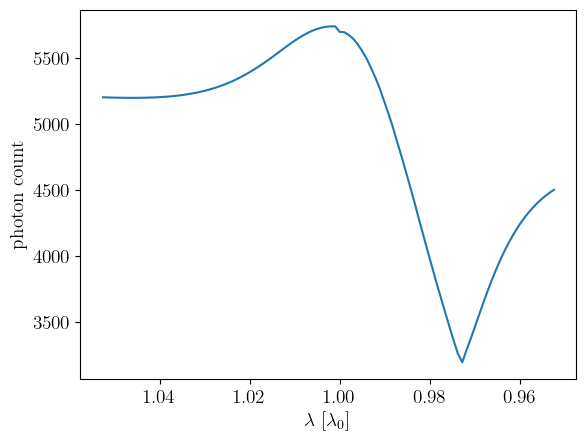

In [17]:
plt.plot(1/(nu_obs/nu0), spec_signal);
plt.gca().invert_xaxis()
plt.xlabel(r'$\lambda~[\lambda_0]$')
plt.ylabel(r'photon count');

# Plot intensity correlator

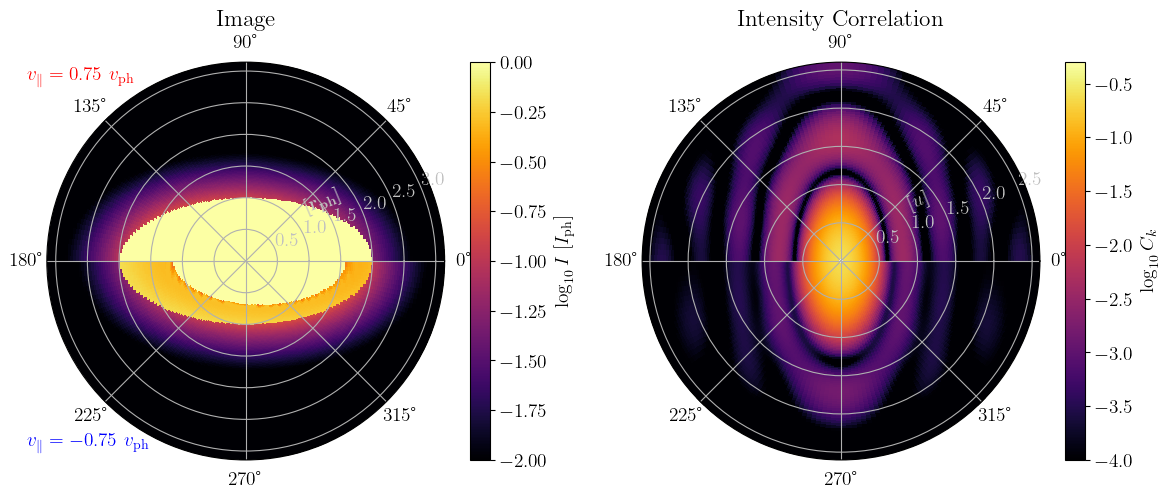

In [18]:
#cmap = mpl.cm.viridis
cmap = mpl.cm.inferno

X,Y = np.meshgrid(p_cyg_signal.ang_obs[0,:,0], 
                  p_cyg_signal.r_ar[:950]/p_cyg_signal.th_max) #rectangular plot of polar data

fig = plt.figure(figsize = (12,5), layout = 'tight')
ax = fig.add_subplot(121, polar = True)
ax.pcolormesh(X + np.pi/200, Y,np.log10(np.abs(image[:950,:,30])), 
              vmax = np.log10(1), vmin = -2, cmap = cmap)
ax.pcolormesh(2*np.pi - X - np.pi/200, Y,np.log10(np.abs(image[:950,:,70])), 
              vmax = np.log10(1), vmin = -2, cmap = cmap)
ax.tick_params(axis='y', colors='silver')
ax.set_title('Image')
#ax.set_ylabel('Radius', rotation=45, size=11)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+15),ax.get_rmax()/2.,r'\textbf{[r$_\text{ph}$]}',
        rotation=label_position,ha='center',va='center', color = 'silver')

ax.text(np.radians(140),4.5,r'$v_\parallel = 0.75~v_\text{ph}$',
        ha = 'left',va='center', color = 'red')

ax.text(np.radians(220),4.5,r'$v_\parallel = -0.75~v_\text{ph}$',
        ha = 'left',va='center', color = 'blue')

norm = mpl.colors.Normalize(vmin=-2, vmax=0)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax = ax, orientation='vertical', label=r'$\log_{10}I~[I_\text{ph}]$')

X,Y = np.meshgrid(p_cyg_signal.ang_obs[0,:,0], p_cyg_signal.k_ar[:280]*p_cyg_signal.th_max/np.pi)

ax = fig.add_subplot(122, polar = True)
ax.pcolormesh(X + np.pi/200, Y,np.log10(np.abs(p_cyg_signal.f_k[:,:280,30].T)), vmax = np.log10(.5), vmin = -4, cmap = cmap)
ax.pcolormesh(2*np.pi - X - np.pi/200, Y,np.log10(np.abs(p_cyg_signal.f_k[:,:280,70].T)), vmax = np.log10(.5), vmin = -4, cmap = cmap)
ax.set_title('Intensity Correlation')
ax.tick_params(axis='y', colors='silver')

#ax.set_ylabel('Radius', rotation=45, size=11)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+15),ax.get_rmax()/2.,r'\textbf{[$u$]}',
        rotation=label_position,ha='center',va='center', color = 'silver')

norm = mpl.colors.Normalize(vmin=-4, vmax=np.log10(.5))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             ax = ax, orientation='vertical', label=r'$\log_{10}C_k$');

#plt.savefig('ellipsoid.pdf', bbox_inches = 'tight')

$\textbf{Left:}$ The image of a asymmetric supernova with $\eta = 2$ and the long axis rotated $\theta = 0.1$. The upper-half of the image is taken at a red-shifted frequency and we can see that there is no absorption in the photosphere and there is emission from the left-half of the supernova ejecta. The lower-half of the image is taken at a blue-shifted frequency and we can see that there is absorption in the photosphere and the emission is coming from the right-half of the supernova.\
\
$\textbf{Right:}$ The intensity correlator map of the image on the right. This would be the image the intensity interferemeter see if we have a whole array of telescopes covering different baselines. We can see that the interference pattern shows the asymmetric between the long and short axis. The lower-half of the intensity correlator map also shows a larger main lobe. This is becasue the effective photosphere is smaller in the corresponding image on the left from the absorption.

# Demonstrate JAX autograd compatibilty for potential MCMC speed up

In [10]:
@jax.grad
def log_likelihood_grad(x):
    v0, ds, tau, n, eta, theta = x
    p_cyg = Correlator_ellipsoid(nu_obs = nu_obs, r_ar = r*th_max_std, nu0 = nu0, v0 = v0,
                                 ds = const.parsec*ds, t = 30*const.day, tau0 = tau, n = n, 
                                 eta = eta, theta = theta,
                                 ang_obs = jnp.arange(0,np.pi,np.pi/100))
    chi2 = jnp.sum((p_cyg.f_k - p_cyg_signal.f_k)**2)
    return -0.5*chi2


@jax.jit
def log_likelihood(x):
    v0, ds, tau, n, eta, theta = x
    p_cyg = Correlator_ellipsoid(nu_obs = nu_obs, r_ar = r*th_max_std, nu0 = nu0, v0 = v0,
                                 ds = const.parsec*ds, t = 30*const.day, tau0 = tau, n = n, 
                                 eta = eta, theta = theta,
                                 ang_obs = jnp.arange(0,np.pi,np.pi/100))

    chi2 = jnp.sum((p_cyg.f_k - p_cyg_signal.f_k)**2)
    return -0.5*chi2

In [11]:
par0 = jnp.array([8e6, 1e7, 2., 5., 2., 0.1])

log_likelihood_grad(par0)

Array([-3.76395977e-20,  2.33596622e-20, -1.49372875e-14,  2.78112744e-14,
       -7.52907825e-14,  7.82766190e-15], dtype=float64)

In [12]:
par1 = jnp.array([7e6, 2e7, 3., 6., 1., 1.])

log_likelihood_grad(par1)

Array([ 7.32882261e-04, -1.99086597e-04,  1.91019598e+02, -2.92742696e+02,
        1.49184802e+03, -1.47599982e+00], dtype=float64)